## Appending CSV files

In [72]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import roc_auc_score

In [105]:
orig_folder = '../../data/CF_User/CFU_val_temp_preds_user/'
final_file = '../../data/CF_User/CFU_val_preds_user.csv'

In [106]:
file_paths = [os.path.join(orig_folder, fn) for fn in os.listdir(orig_folder)]

In [107]:
parts = [pd.read_csv(csv_file) for csv_file in file_paths]

In [108]:
final_df = pd.concat(parts)

In [109]:
final_df.to_csv(final_file, index=False)

In [110]:
len(final_df)

639494

## Joining CSV files

In [111]:
import pandas as pd
import numpy as np
import os

In [132]:
orig_folder = '../../data/test_stuff/'
final_file = '../../data/merged.csv'

In [113]:
file_paths = [os.path.join(orig_folder, fn) for fn in os.listdir(orig_folder)]

In [126]:
parts = [pd.read_csv(csv_file) for csv_file in file_paths]

In [127]:
merged_data = parts[0]

In [129]:
for part in parts[1:]:
    merged_data = pd.merge(left=merged_data, right=part, on=['movie_id', 'user_id', 'y_true'], validate='one_to_one')

In [130]:
len(merged_data)

625399

In [133]:
merged_data.to_csv(final_file, index=False)

## DF to PredictionHandler

In [153]:
class PredictionHandler(object):
    def __init__(self, ground_truth):
        self._predictions = {'ground_truth': ground_truth}
        self._num_preds = len(ground_truth)
        
    def add_prediction(self, model_name, predictions):
        if len(predictions) != self._num_preds:
            raise "Number of predictions different from the ground truth."
        self._predictions[model_name] = predictions
    
    def get_models_list(self):
        return list(self._predictions.keys())
    
    def get_predictions(self, model_name=None):
        if model_name and model_name in self._predictions:
            return self._predictions[model_name]
        else:
            return self._predictions


def df_to_prediction_handler(df):
    y_true = np.array(df['y_true'].values)
    predicted_df = df.drop(columns=['user_id', 'movie_id', 'y_true'])
    columns = predicted_df.columns
    
    prediction_handler = PredictionHandler(ground_truth=y_true)
    for model_name in columns:
        prediction_handler.add_prediction(model_name, 
                                          np.array(df[model_name].values))
        
    return prediction_handler

In [154]:
import pandas as pd
import numpy as np
import os

In [155]:
merged_handler = df_to_prediction_handler(merged_data)

In [144]:
[len(merged_handler.get_predictions(model)) for model in merged_handler.get_models_list()]

[625399, 625399, 625399, 625399]

In [148]:
merged_handler.get_models_list()

['ground_truth', 'CF_User', 'CF_Item', 'LFM']

## Performance Analyzer

In [150]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error
import matplotlib.pyplot as plt
from math import sqrt

%matplotlib inline

In [187]:
class PerformanceAnalyzer(object):
    
    def __init__(self, prediction_handler: PredictionHandler, 
                 roc_thresholds=[3], rmse_thresholds=[0]):
        self._prediction_handler = prediction_handler
        self._ground_truth_label = 'ground_truth'
        self._model_names = self._prediction_handler.get_models_list()
        self._model_names.remove(self._ground_truth_label)
        self._roc_thresholds = roc_thresholds
        self._rmse_thresholds = rmse_thresholds
    
    
    def _rmse_at_threshold(self, y_true, y_pred, threshold):
        indices = y_true >= threshold
        rmse = sqrt(mean_squared_error(y_true[indices], y_pred[indices]))
        return rmse
    
    
    def _roc_at_threshold(self, y_true, y_pred, threshold):
        
        # Threshold ground truth ratings
        y_true_thresh = np.where(y_true >= threshold, 1, 0)
        
        # Scale the predictions to bring them to 0-1 range from 0-5 range
        y_pred_scaled = y_pred / 5
        
        # Calculate the area under the ROC curve
        area = roc_auc_score(y_true_thresh, y_pred_scaled)
        
        return area
    
    
    def get_scores(self):
        scores = {}
        y_true = self._prediction_handler.get_predictions(self._ground_truth_label)
        
        for roc_threshold in self._roc_thresholds:
            metric_name = 'roc_auc_at_' + str(roc_threshold)
            score_metric = {}
            for model in self._model_names:
                score_metric[model] = self._roc_at_threshold(y_true, 
                                                             self._prediction_handler.get_predictions(model), 
                                                             roc_threshold)
            scores[metric_name] = score_metric
            
        for rmse_threshold in self._rmse_thresholds:
            metric_name = 'rmse_at_' + str(rmse_threshold)
            score_metric = {}
            for model in self._model_names:
                score_metric[model] = self._rmse_at_threshold(y_true, 
                                                              self._prediction_handler.get_predictions(model), 
                                                              rmse_threshold)
            scores[metric_name] = score_metric
        
        return scores
    
    
    def plot_roc_at_threshold(self, output_file, threshold=3):
        plt.rcParams['figure.figsize'] = [8, 8]
        
        # Threshold ground truth ratings
        y_true = np.where(self._prediction_handler.get_predictions(self._ground_truth_label) >= threshold, 
                          1, 0)
        plt.plot([0, 1], [0, 1], 'k--')
        for model in self._model_names:
            y_pred = self._prediction_handler.get_predictions(model)
            fpr, tpr, thresh = roc_curve(y_true, y_pred)
            auc = roc_auc_score(y_true, y_pred)
            plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (model, auc))
            
        plt.xlabel('Specificity (False Positive Rate)')
        plt.ylabel('Sensitivity (True Positive Rate)')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.savefig(output_file)
    
    def get_models_list(self):
        return self._model_names
    

In [189]:
ph = PerformanceAnalyzer(merged_handler, roc_thresholds=[2.5, 3, 3.5], 
                         rmse_thresholds=[0, 2.5, 3, 3.5])

In [190]:
pd.DataFrame.from_dict(ph.get_scores())

,roc_auc_at_2.5,roc_auc_at_3,roc_auc_at_3.5,rmse_at_0,rmse_at_2.5,rmse_at_3,rmse_at_3.5
CF_Item,0.747106,0.741582,0.729348,1.038232,0.890805,0.877066,0.885455
CF_User,0.764403,0.760409,0.747938,0.939172,0.782601,0.774618,0.801479
LFM,0.835386,0.835011,0.813166,0.820836,0.671772,0.665800,0.689381


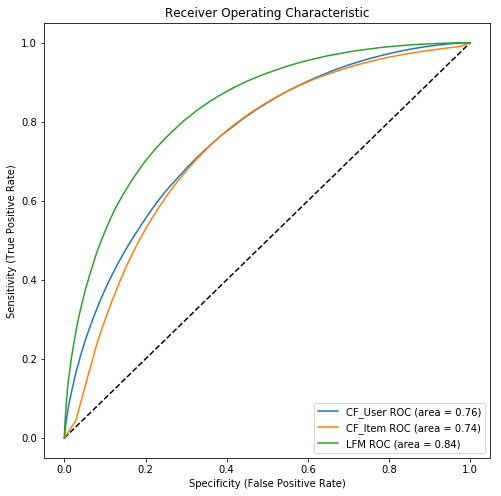

In [191]:
ph.plot_roc_at_threshold('')